# Classification model on Cardiotocography dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l2
import multiprocessing as mp
from time import time


import os
if not os.path.isdir('figures'):
    os.makedirs('figures')

## Set parameters
The batch size is not initialized here as it will be tested later.

In [2]:
lr = 0.01
no_folds = 5
no_epochs = 1000
beta = 0.000001

NO_INPUTS = 21
no_neurons = 10
NO_CLASSES = 3


seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

## Read data

In [3]:
# read in data from csv file
df = pd.read_csv('ctg_data_cleaned.csv')
df=df.values

In [4]:
# data
# generate training data from csv file

# inputs are the first 21 columns
X = df[:,0:21]
# normalizing every input
max_arr = np.max(X, axis = 0)
min_arr = np.min(X, axis = 0)
for i in range(2126):
    for j in range(21):
        X[i,j] = (X[i,j] - min_arr[j])/(max_arr[j] - min_arr[j])

# target is the last column
Y = df[:,22]
# convert [1,2,3] to [0,1,2] as class label starts from 0
Y -= 1
Y = Y.reshape(2126,1).astype(int)

# split training and testing sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42) 

## Implement 5-cross validation
Use 5-cross validation to determine the best batch size. The batch size should be passed in as a parameter.

In [5]:
# min and max value for weight initialization
w_min_relu = -np.sqrt(6)/np.sqrt(NO_INPUTS+no_neurons)
w_max_relu = np.sqrt(6)/np.sqrt(NO_INPUTS+no_neurons)
w_min_softmax = -4*np.sqrt(6)/np.sqrt(no_neurons+NO_CLASSES)
w_max_softmax = 4*np.sqrt(6)/np.sqrt(no_neurons+NO_CLASSES)

# number of patterns in each fold
nf = len(x_train)//no_folds

def train(batch_size):
    acc_matrix = np.zeros((no_folds,no_epochs)) 
    total_time = 0
    for fold in range(no_folds):
        start, end = fold*nf, (fold+1)*nf
        # Set the end index for the last fold to cover all training data
        if fold == 4:
            end == 1488
        
        x_train_test, y_train_test = x_train[start:end], y_train[start:end]
        x_train_train  = np.append(x_train[:start], x_train[end:], axis=0)
        y_train_train = np.append(y_train[:start], y_train[end:], axis=0) 
        
        model = Sequential([Dense(no_neurons, activation='relu', 
                          kernel_initializer=RandomUniform(w_min_relu, w_max_relu), 
                          kernel_regularizer=l2(beta)),
                    Dense(NO_CLASSES, activation='softmax', 
                          kernel_initializer=RandomUniform(w_min_softmax, w_max_softmax),
                          kernel_regularizer=l2(beta))])
        
        model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        
        startTime = time()
        history = model.fit(x_train_train, y_train_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=0,
                    use_multiprocessing=True,
                    validation_data=(x_train_test, y_train_test))
        total_time += time()-startTime
        
        for i in range (no_epochs):
            acc_matrix[fold,:] = history.history['val_accuracy']

    acc = np.mean(acc_matrix, axis = 0)
    epoch_time = total_time/(no_folds*no_epochs)
    return acc, epoch_time 

    


## Compare performance
Using batch size = 4, 8, 16, 32, 64, print the accuracies and execution time.

In [6]:
acc_4, epoch_time_4 = train(4)
acc_8, epoch_time_8 = train(8)
acc_16,epoch_time_16 = train(16)
acc_32, epoch_time_32 = train(32)
acc_64, epoch_time_64 = train(64)

In [7]:
print('The cross-validation accuracy of batch size 4 is: %g' %acc_4[no_epochs - 1])
print('The cross-validation accuracy of batch size 8 is: %g' %acc_8[no_epochs - 1])
print('The cross-validation accuracy of batch size 16 is: %g' %acc_16[no_epochs - 1])
print('The cross-validation accuracy of batch size 32 is: %g' %acc_32[no_epochs - 1])
print('The cross-validation accuracy of batch size 64 is: %g' %acc_64[no_epochs - 1])

The cross-validation accuracy of batch size 4 is: 0.902357
The cross-validation accuracy of batch size 8 is: 0.900337
The cross-validation accuracy of batch size 16 is: 0.891583
The cross-validation accuracy of batch size 32 is: 0.89697
The cross-validation accuracy of batch size 64 is: 0.896296


In [8]:
print('The training time for one epoch of batch size 4 is: %g' %epoch_time_4)
print('The training time for one epoch of batch size 8 is: %g' %epoch_time_8)
print('The training time for one epoch of batch size 16 is: %g' %epoch_time_16)
print('The training time for one epoch of batch size 32 is: %g' %epoch_time_32)
print('The training time for one epoch of batch size 64 is: %g' %epoch_time_64)

The training time for one epoch of batch size 4 is: 0.421754
The training time for one epoch of batch size 8 is: 0.247586
The training time for one epoch of batch size 16 is: 0.161948
The training time for one epoch of batch size 32 is: 0.113264
The training time for one epoch of batch size 64 is: 0.0903555


## Plot accuracy and time curves

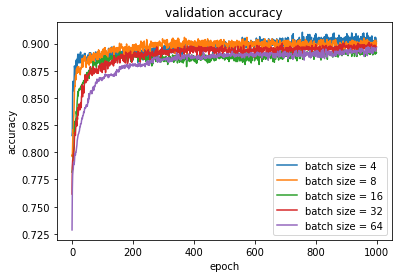

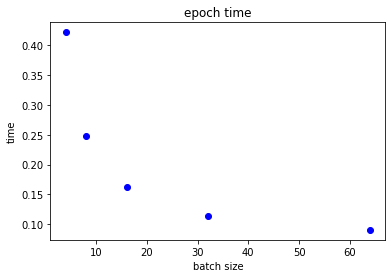

In [9]:
# summarize accuracy
plt.plot(acc_4)
plt.plot(acc_8)
plt.plot(acc_16)
plt.plot(acc_32)
plt.plot(acc_64)
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['batch size = 4', 'batch size = 8', 'batch size = 16', 'batch size = 32', 'batch size = 64'], loc='lower right')
plt.savefig("2aAcc.png")
plt.show()


# summarize epoch time
plt.plot(4, epoch_time_4, 'bo')
plt.plot(8, epoch_time_8,'bo')
plt.plot(16, epoch_time_16, 'bo')
plt.plot(32, epoch_time_32, 'bo')
plt.plot(64, epoch_time_64, 'bo')
plt.title('epoch time')
plt.ylabel('time')
plt.xlabel('batch size')
plt.savefig("2aTime.png")
plt.show()

